In [2]:
import numpy as np
from scipy.fftpack import fft, rfft, fftshift
from scipy.signal.windows import hann
import matplotlib.pyplot as plt
from cca.synth_data import gen_gp_kernel, sample_gp, calc_pi_for_gp
from math import floor, ceil

from cca import cca

In [3]:
def calc_pi_cepstral(x, chunk_size=100):
    #Reshape and window the data
    x_trunc = x[:len(x) - (len(x) % chunk_size)]
    x_reshape = np.reshape(x_trunc, (len(x_trunc)//chunk_size, chunk_size))
    x_reshape *= hann(chunk_size)
    
    #Compute power spectral density
    S = np.abs(fft(x_reshape, axis=1))**2
    print(S.shape)
    S_avg = fftshift(np.mean(S, axis=0))
    
    #Compute DFT of autocorrelation function (divide by chunk_size)
    f = S_avg / chunk_size
    
    #Compute {b_k} (divide by chunk_size)
    b_k = np.abs(fft( np.log(f) )) / chunk_size
    b_k = b_k[:chunk_size//2]
    
    #Compute PI
    pi = 0.5*np.sum( b_k**2 * np.arange(len(b_k)) )
    return pi

In [14]:
x = np.random.normal(0, 1, 20000)
calc_pi_cepstral(x, chunk_size=50)

(400, 50)


0.0034239975028352537

tau = 1.0
(500, 200)
tau = 5.061224489795919
(500, 200)
tau = 9.122448979591837
(500, 200)
tau = 13.183673469387756
(500, 200)
tau = 17.244897959183675
(500, 200)
tau = 21.306122448979593
(500, 200)
tau = 25.367346938775512
(500, 200)
tau = 29.42857142857143
(500, 200)
tau = 33.48979591836735
(500, 200)
tau = 37.55102040816327
(500, 200)
tau = 41.61224489795919
(500, 200)
tau = 45.673469387755105
(500, 200)
tau = 49.734693877551024
(500, 200)
tau = 53.79591836734694
(500, 200)
tau = 57.85714285714286
(500, 200)
tau = 61.91836734693878
(500, 200)
tau = 65.9795918367347
(500, 200)
tau = 70.04081632653062
(500, 200)
tau = 74.10204081632654
(500, 200)
tau = 78.16326530612245
(500, 200)
tau = 82.22448979591837
(500, 200)
tau = 86.28571428571429
(500, 200)
tau = 90.34693877551021
(500, 200)
tau = 94.40816326530613
(500, 200)
tau = 98.46938775510205
(500, 200)
tau = 102.53061224489797
(500, 200)
tau = 106.59183673469389
(500, 200)
tau = 110.6530612244898
(500, 200)
tau = 114.71428571428572
(5

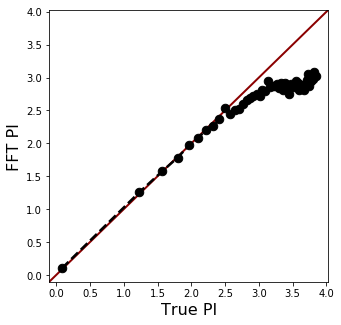

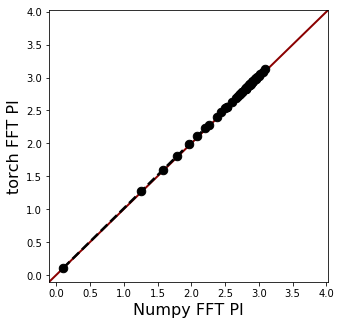

In [4]:
T = 200
num_to_concat = 500 #5000
n = T*num_to_concat
sigma = 0.05

chunk_size = 200
T_pi = 600

tau_vals = np.linspace(1.0, 200.0, 50)
pi_cepstral_vals, pi_true_vals, pi_cepstral_vals_t = [np.zeros_like(tau_vals) for _ in range(3)]
for tau_idx in range(len(tau_vals)):
    tau = tau_vals[tau_idx]
    print("tau =", tau)
    K = gen_gp_kernel("squared_exp", temporal_scale=tau, spatial_scale=1, local_noise=sigma)
    x = sample_gp(T, 1, K, num_to_concat).flatten()
    pi_cepstral_vals_t[tau_idx] = cca.pi_fft_loss_fn(x[:, np.newaxis], chunk_size)
    pi_cepstral_vals[tau_idx] = calc_pi_cepstral(x, chunk_size=chunk_size)
    pi_true_vals[tau_idx] = calc_pi_for_gp(K, T_pi, 1)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
all_vals = np.concatenate((pi_true_vals, pi_cepstral_vals))
min_val, max_val = np.min(all_vals), np.max(all_vals)
val_range = max_val - min_val
min_window, max_window = min_val - 0.05*val_range, max_val + 0.05*val_range
ax.set_xlim([min_window, max_window])
ax.set_ylim([min_window, max_window])
t = np.linspace(min_window, max_window, 100)
ax.plot(t, t, c="darkred", zorder=0, linestyle="-", linewidth=2)
ax.plot(pi_true_vals, pi_cepstral_vals, c="black", linestyle="--", marker=".", markersize=17, linewidth=2.5)
ax.set_xlabel("True PI", fontsize=16)
ax.set_ylabel("FFT PI", fontsize=16)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
all_vals = np.concatenate((pi_true_vals, pi_cepstral_vals))
min_val, max_val = np.min(all_vals), np.max(all_vals)
val_range = max_val - min_val
min_window, max_window = min_val - 0.05*val_range, max_val + 0.05*val_range
ax.set_xlim([min_window, max_window])
ax.set_ylim([min_window, max_window])
t = np.linspace(min_window, max_window, 100)
ax.plot(t, t, c="darkred", zorder=0, linestyle="-", linewidth=2)
ax.plot(pi_cepstral_vals, pi_cepstral_vals_t, c="black", linestyle="--", marker=".", markersize=17, linewidth=2.5)
ax.set_xlabel("Numpy FFT PI", fontsize=16)
ax.set_ylabel("torch FFT PI", fontsize=16)
plt.show()

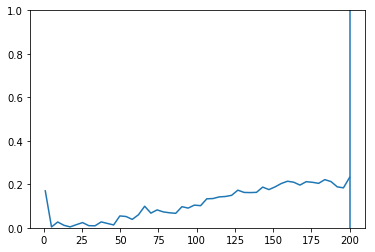

In [46]:
err = np.abs(pi_cepstral_vals - pi_true_vals)/pi_true_vals
plt.plot(tau_vals, err)
plt.ylim([0, 1])
plt.axvline(chunk_size)